# Creating the Figures for the Manuscript

### Date: 2025-03-26

# Setup

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from metadata import simulation_num_to_name_mapping

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.25)

### Loading the DataFrames of Simulation Data

In [4]:
sim_names = list(simulation_num_to_name_mapping.keys())
sim_names.remove("Highly correlated luck model")

sim_populations = {}
sim_pop_over_time = {}
sim_cross_sectional = {}
sim_cross_sectional_zombie = {}

for sim_name in sim_names:
    temp_df = pd.read_csv(f"./results/simulation_datasets/{sim_name}/population.csv", index_col=0)
    sim_populations[sim_name] = temp_df

    temp_df = pd.read_csv(f"./results/simulation_datasets/{sim_name}/population_over_time.csv", index_col=0)
    sim_pop_over_time[sim_name] = temp_df


### Model Mortality for All Simulations 

In [5]:
sim_model_mortality = {}

for sim_name, population in sim_populations.items():
    model_mortality = population['age_of_death'].value_counts()

    for age in range(0, 81):
        if age not in model_mortality.index:
            model_mortality.loc[age] = 0

    model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
    model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
    model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()

    sim_model_mortality[sim_name] = model_mortality

In [6]:
all_sims_mortality = pd.DataFrame()

for sim_name, mortality in sim_model_mortality.items():
    mortality['Model'] = sim_name
    all_sims_mortality = pd.concat([all_sims_mortality, mortality])    

In [7]:
# Changed the names of the models
sim_name_replacement = {
    'Mediumly correlated luck model': 'Medium correlated luck model',
    'Highly correlated luck model': 'High correlated luck model',
}

In [8]:
real_world_mortality = pd.read_csv("./luck_vs_circumstance/datasets/2019_Life_Table_data.csv", index_col=0)
real_world_mortality.rename(columns={'VALUE': 'Model survivors at age x', 'Age group': 'age'}, inplace=True)
real_world_mortality["Model"] = "2019 Canadian Empirical Data"
real_world_mortality['age'] = real_world_mortality.age.str.replace("\D+", "", regex=True).astype(int)
real_world_mortality = real_world_mortality[real_world_mortality.age <= 80]
real_world_mortality['Model survivors at age x'] = real_world_mortality['Model survivors at age x'] / 10
all_sims_mortality = pd.concat([all_sims_mortality, real_world_mortality])
all_sims_mortality['Model'] = all_sims_mortality['Model'].replace(sim_name_replacement).str.title()

# Figures

## Figure 1: Survival Curves 

/tmp/ipykernel_546563/2030117170.py:8: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(data=all_sims_mortality, x='age', y='Model survivors at age x', hue='Model', ax=axs, palette=modified_palette)


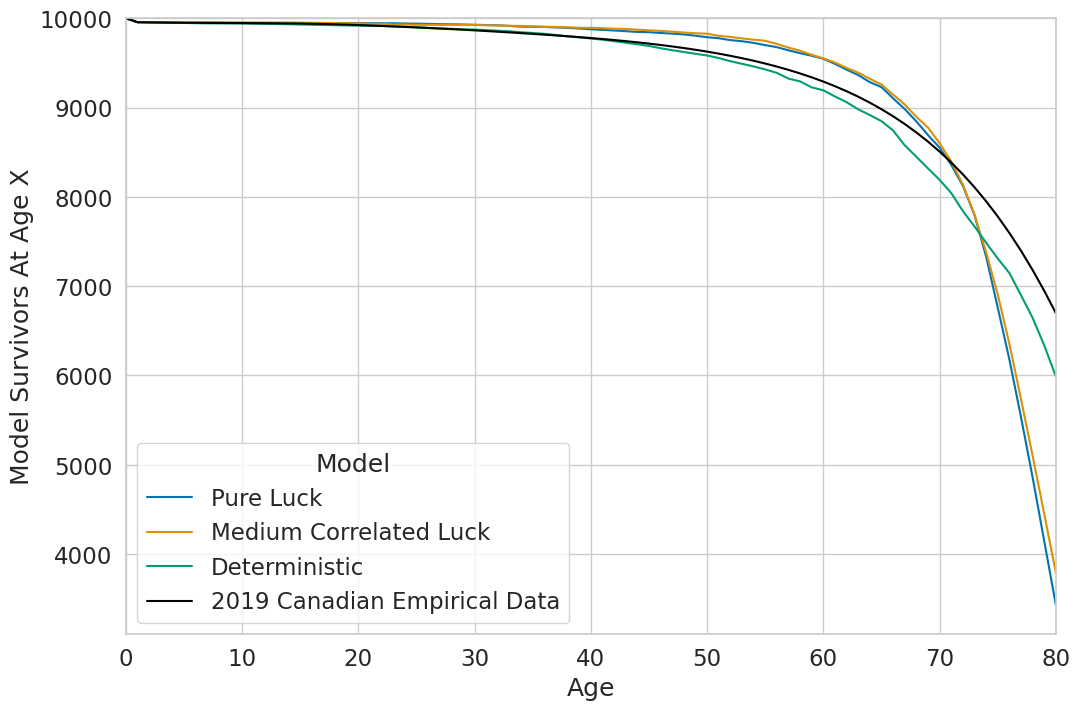

In [9]:
# Modified to have the real world be black
modified_palette = list(sns.color_palette())
modified_palette[3] = (0,0,0)

sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(figsize=(12,8))
sns.lineplot(data=all_sims_mortality, x='age', y='Model survivors at age x', hue='Model', ax=axs, palette=modified_palette)
axs.set_xlim(0, 80)
axs.set_ylim(top=10_000)
axs.legend(labels=[label.rstrip(" Model") for label in axs.get_legend_handles_labels()[1]], handles=axs.get_legend_handles_labels()[0])
axs.get_legend().set_title("Model")
axs.set_ylabel(axs.get_ylabel().title())
axs.set_xlabel(axs.get_xlabel().title())

fig.savefig("./figures/manuscript_figures/Figure_1.png", dpi=600, bbox_inches='tight')

## Survival Curves by Effort and Circumstance

In [10]:
sns.set_context("notebook", font_scale=1.25)

In [11]:

def plot_inequity_mortality_curves(population, c_or_e: str, index=None, number_of_years=80, normalize_e=False):
    population = population.copy()
    # population_over_time = lvc_model.population_over_time.copy()

    if c_or_e == "c":
        min_pop = population[population.circumstance_score == population.circumstance_score.min()]
        max_pop = population[population.circumstance_score == population.circumstance_score.max()]
        mid_pop = population[population.circumstance_score == population.circumstance_score.median()]
    elif c_or_e == "e" and normalize_e == False:
        population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, 0.1, 0.45, 0.55, 0.9, 1.0])
        min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
        max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
        mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]] 
    elif c_or_e == "e" and normalize_e == True:
        cdv = population.circumstance_score.value_counts(normalize=True).sort_index()
        population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, cdv.iloc[0], 0.5 - (cdv.iloc[3] / 2), 0.5 + (cdv.iloc[3] / 2), 1.0 - cdv.iloc[6], 1.0])
        min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
        max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
        mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]]
    else:
        raise ValueError("c_or_e must be 'c' or 'e'")

    sub_pop_model_mortalities = []

    for sub_pop in (population, min_pop, max_pop, mid_pop):   
        model_mortality = sub_pop['age_of_death'].value_counts(normalize=True)

        # Added the plus one to the number of years as this fixes a reshaping bug 
        # that occurs when everyone is dead before the end of the timeline
        for age in range(0, number_of_years + 1):
            if age not in model_mortality.index:
                model_mortality.loc[age] = 0

        model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
        model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
        model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()
        model_mortality['Model survivors at age x'] = model_mortality['Model survivors at age x'] * 100
        model_mortality = model_mortality

        sub_pop_model_mortalities.append(model_mortality)

    population_mortality, min_pop_mortality, max_pop_mortality, mid_pop_mortality = sub_pop_model_mortalities

    cmap = sns.color_palette('flare', n_colors=9)
    # Plotting the mortality data
    fig, ax1 = plt.subplots()

    score_str = "Circumstance" if c_or_e == "c" else "Effort"

    if c_or_e == 'c':
        # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
        ax1.plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Circumstance", color=cmap[0])
        ax1.plot(mid_pop_mortality.iloc[:, 1], label=f"Median Circumstance", color=cmap[3])
        ax1.plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Circumstance", color=cmap[8])
    else:
        # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
        ax1.plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Effort", color=cmap[0])
        ax1.plot(mid_pop_mortality.iloc[:, 1], label=f"Median Effort", color=cmap[3])
        ax1.plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Effort", color=cmap[8])

    # Adding some labels and title
    ax1.set_ylabel("Percentage of Survivors")
    ax1.set_xlabel("Age")
    ax1.set_title(f"Survival Curves by {score_str}")
    ax1.legend(loc='lower left', title="")

    fig.tight_layout()
    ax1.set_xlim(0, 80)
    ax1.set_ylim(top=100, bottom=0)

    return fig

In [12]:
def plot_inequity_mortality_curves_for_all_simulations(sim_populations, c_or_e: str, index=None, number_of_years=80, normalize_e=False):

    # Create figure with 2 rows, 4 columns for centering
    fig = plt.figure(figsize=(12, 8))
    
    # Create custom subplot layout using GridSpec
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(2, 4, figure=fig)
    
    # First row: two subplots (each spanning 2 columns)
    ax1_00 = fig.add_subplot(gs[0, 0:2])
    ax1_01 = fig.add_subplot(gs[0, 2:4])
    # Second row: one centered subplot (spanning middle 2 columns)
    ax1_10 = fig.add_subplot(gs[1, 1:3])
    
    # Store axes in a list for easier access
    axes_list = [ax1_00, ax1_01, ax1_10]
    
    for i, (sim, population) in enumerate(sim_populations.items()):
        population = population.copy()

        # Get the appropriate axis
        ax = axes_list[i]

        if c_or_e == "c":
            min_pop = population[population.circumstance_score == population.circumstance_score.min()]
            max_pop = population[population.circumstance_score == population.circumstance_score.max()]
            mid_pop = population[population.circumstance_score == population.circumstance_score.median()]
        elif c_or_e == "e" and normalize_e == False and sim != 'Pure luck model':
            population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, 0.1, 0.45, 0.55, 0.9, 1.0])
            min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
            max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
            mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]] 
        elif c_or_e == "e" and normalize_e == False and sim == 'Pure luck model':
            min_pop = population
            max_pop = population
            mid_pop = population
        elif c_or_e == "e" and normalize_e == True:
            cdv = population.circumstance_score.value_counts(normalize=True).sort_index()
            population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, cdv.iloc[0], 0.5 - (cdv.iloc[3] / 2), 0.5 + (cdv.iloc[3] / 2), 1.0 - cdv.iloc[6], 1.0])
            min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
            max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
            mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]]
        else:
            raise ValueError("c_or_e must be 'c' or 'e'")

        sub_pop_model_mortalities = []

        for sub_pop in (population, min_pop, max_pop, mid_pop):   
            model_mortality = sub_pop['age_of_death'].value_counts(normalize=True)

            # Added the plus one to the number of years as this fixes a reshaping bug 
            # that occurs when everyone is dead before the end of the timeline
            for age in range(0, number_of_years + 1):
                if age not in model_mortality.index:
                    model_mortality.loc[age] = 0

            model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
            model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
            model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()
            model_mortality['Model survivors at age x'] = model_mortality['Model survivors at age x'] * 100
            model_mortality = model_mortality

            sub_pop_model_mortalities.append(model_mortality)

        population_mortality, min_pop_mortality, max_pop_mortality, mid_pop_mortality = sub_pop_model_mortalities

        cmap = sns.color_palette('flare', n_colors=9)
        
        # Plotting the mortality data
        score_str = "Circumstance" if c_or_e == "c" else "Effort"

        if c_or_e == 'c':
            ax.plot(min_pop_mortality.iloc[:, 1], label=f"Worst", color=cmap[0])
            ax.plot(mid_pop_mortality.iloc[:, 1], label=f"Middle", color=cmap[3])
            ax.plot(max_pop_mortality.iloc[:, 1], label=f"Best", color=cmap[8])
        else:
            ax.plot(min_pop_mortality.iloc[:, 1], label=f"Minimum Effort", color=cmap[0])
            ax.plot(mid_pop_mortality.iloc[:, 1], label=f"Median Effort", color=cmap[3])
            ax.plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Effort", color=cmap[8])

        # Adding some labels and title
        ax.set_ylabel("% Population")
        ax.set_xlabel("Age")
        ax.set_title(f"{sim.replace('ly', '').title().rstrip(' Model')}")
        ax.legend().remove()
        ax.set_xlim(0, 80)
        ax.set_ylim(top=100, bottom=0)

    fig.legend(labels=[label for label in axes_list[0].get_legend_handles_labels()[1]], 
               handles=axes_list[0].get_legend_handles_labels()[0], 
               loc="lower center", bbox_to_anchor=(0.5,-0.05), ncol=4, 
               title='', fontsize=13).get_frame().set_linewidth(0.0)
    
    fig.tight_layout()

    return fig

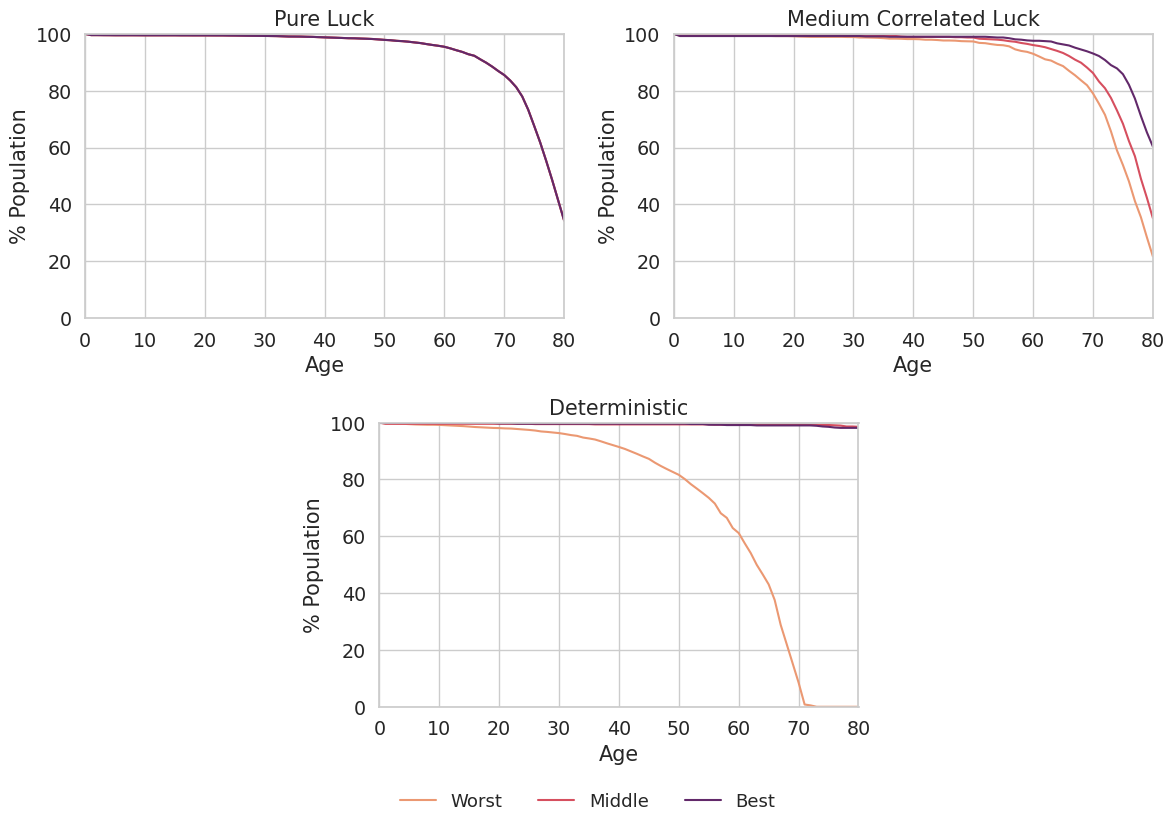

In [13]:
fig = plot_inequity_mortality_curves_for_all_simulations(sim_populations, c_or_e='c')
fig.show()

fig.savefig("./figures/appendix_figures/Appendix_8.png", dpi=600, bbox_inches='tight')

## Population Surviving to Age 80

In [14]:
from luck_vs_circumstance import dist, params

def plot_proportion_of_deaths_by_circumstance_score(sim_populations):
    prop_frame = pd.DataFrame()

    plt.figure(figsize=(12,8))

    for sim_num in sim_populations.keys():
        if sim_num == "Pure luck model":
            # Adding imaginary noise to simulation 0
            canada_education, _, _ = params.parse_empirical_data("/home/yann/health_inequity_simulation/luck_vs_circumstance/datasets")
            c_dist = dist.Circumstance_Distribution(canada_education['Circumstance_Score'], canada_education['Proportion'])
            population = sim_populations[sim_num].copy()
            population['circumstance_score'] = c_dist.draw(10000)
        else:
            population = sim_populations[sim_num].copy()

        # population = population[~population.cause_of_death.isin(['accidental', 'neonatal'])]
        temp = population.groupby('circumstance_score').age_of_death.value_counts(True).to_frame().reset_index()
        subtemp = temp[temp.age_of_death == 80].copy()
        for c in population.circumstance_score.unique():
            if c not in subtemp.circumstance_score.unique():
                subtemp = pd.concat([subtemp, pd.DataFrame({'circumstance_score': c, 'age_of_death': 80, 'proportion': 0}, index=[0])])
        subtemp = subtemp.sort_values('circumstance_score')
        subtemp['simulation'] = str(sim_num)
        prop_frame = pd.concat([prop_frame, subtemp])
        prop_frame['simulation'] = prop_frame.simulation.replace(sim_name_replacement).str.title()

    prop_frame['proportion'] = prop_frame['proportion'] * 100
    fig = sns.lineplot(data=prop_frame, x='circumstance_score', y='proportion', hue='simulation', marker='o', markersize=8)# , title="Proportion of Agents surviving to age 80 by Circumstance")

    return fig

<frozen importlib._bootstrap>:241: RuntimeWarning: neworder installed in serial mode. If necessary, enable MPI with: pip install neworder[parallel]


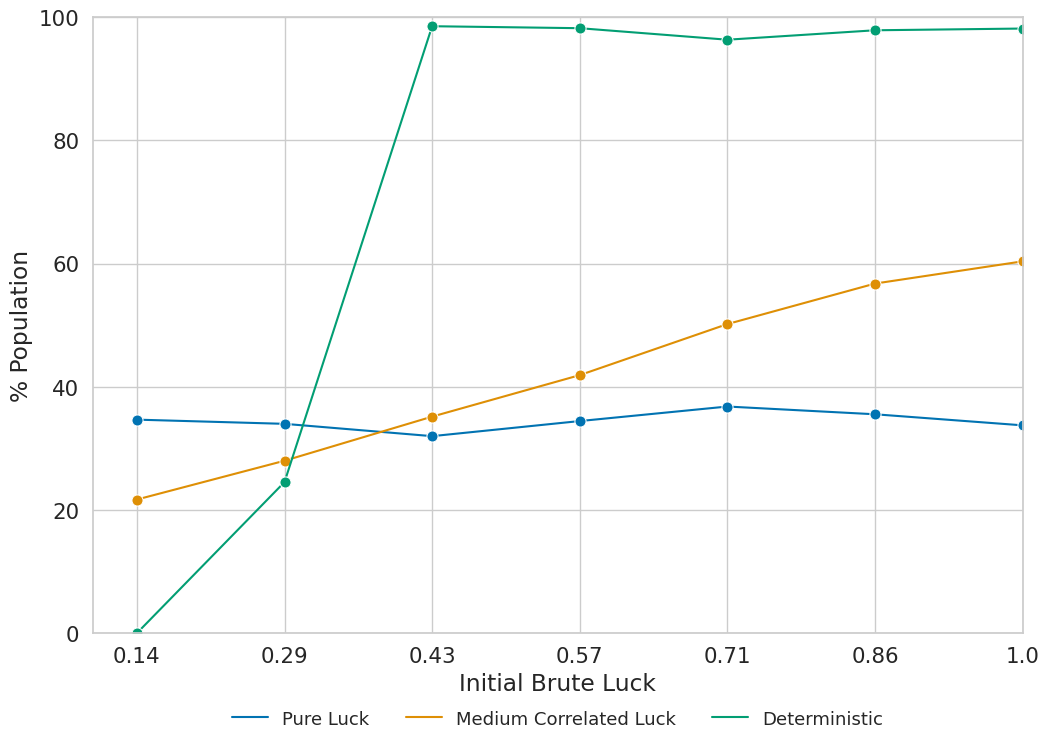

In [15]:
sns.set_context("notebook", font_scale=1.4)

fig = plot_proportion_of_deaths_by_circumstance_score(sim_populations)
fig.set_xlabel("Initial Brute Luck")
fig.set_ylabel("% Population")
fig.set_xlim(right=1)
fig.set_ylim(top=100, bottom=0)
fig.set_xticks(sorted(sim_populations['Deterministic model'].circumstance_score.unique()), labels=[0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00])
fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.18), ncol=4, title='', fontsize=13) #, fontsize=12, title_fontsize=12)
leg = fig.get_legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig("./figures/manuscript_figures/Figure_3.png", dpi=600, bbox_inches='tight')

## Loading the Data from Excel files

In [16]:
sns.set_context("notebook", font_scale=1.5)

### Loading the Gini Analysis Data from the Excel File

In [17]:
dataset = "./Gini_lifecourse_cross-sectional_31JAN2025.xlsx"

#### Life Course Gini Graph Sheet Data

In [18]:
gini_life_course_df = pd.read_excel(dataset, sheet_name="life course Gini graph")

In [19]:
gini_life_course_df = gini_life_course_df.dropna(how='all').iloc[1:]

In [20]:
gini_life_course_df = gini_life_course_df.rename(columns={'This corresponds to Figure R2 & Figure R3': 'Analysis', 'Unnamed: 1': 'Method', 'Unnamed: 2': 'Model', 'Unnamed: 3': 20, 'Unnamed: 4': 40, 'Unnamed: 5': 60, 'Unnamed: 6': 80,})

In [21]:
gini_life_course_df = gini_life_course_df.reset_index().drop(columns='index')

In [22]:
name_replacement = {0: 'Pure Luck Model', 4: 'Correlated Luck Model', 9: 'High Correlated Luck Model', 12: 'Deterministic Model'}

In [23]:
gini_life_course_df['Model'] = gini_life_course_df.Model.replace(name_replacement)

In [24]:
gini_df = gini_life_course_df.iloc[:17]
percent_dead_df = gini_life_course_df.iloc[17:22]
below_point_five_df = gini_life_course_df[22:]

#### Gini Graph Data

In [25]:
gini_df = gini_df[gini_df.Model != 'Model'].copy()

In [26]:
gini_df['Analysis'] = gini_df.Analysis.fillna(method='ffill')
gini_df['Method'] = gini_df.Method.fillna(method='ffill', limit=3)

In [27]:
gini_df = gini_df.melt(id_vars=['Analysis', 'Method', 'Model'], value_vars=[20, 40, 60, 80])

#### Percent Dead Data

In [28]:
percent_dead_df = percent_dead_df.iloc[1:]

In [29]:
percent_dead_df = percent_dead_df.drop(columns=['Analysis', 'Method'])

In [30]:
percent_dead_df = percent_dead_df.melt(id_vars=['Model'], value_vars=[20, 40, 60, 80])

In [31]:
percent_dead_df['Model'] = percent_dead_df.Model.replace(name_replacement)

#### % Below 0.5 Data

In [32]:
below_point_five_df = below_point_five_df.iloc[1:].copy()

In [33]:
below_point_five_df['Analysis'] = below_point_five_df.Analysis.fillna(method='ffill')

In [34]:
below_point_five_df = below_point_five_df.drop(columns='Method').rename(columns={'Analysis': 'Method'})

In [35]:
below_point_five_df = below_point_five_df[below_point_five_df.Model != 'Model'].copy()

In [36]:
below_point_five_df = below_point_five_df.melt(id_vars=['Method', 'Model'], value_vars=[20, 40, 60, 80])

In [37]:
below_point_five_df['Model'] = below_point_five_df.Model.replace(name_replacement)

## Gini Life-course

## Health Score Below 0.5

In [38]:
sns.set_context("notebook", font_scale=1.4)

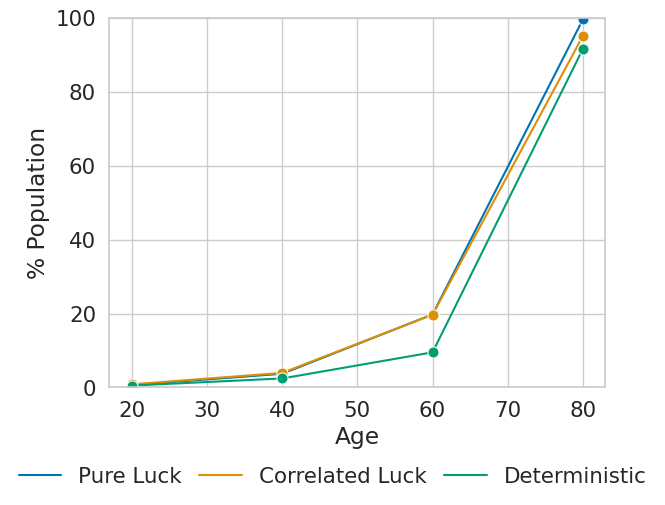

In [39]:
# OLD APPENDIX 7
# NEW APPENDIX 6

fig = sns.lineplot(data=below_point_five_df[(below_point_five_df['Method'] == 'dead included') & (below_point_five_df['Model'] != 'High Correlated Luck Model')], hue='Model', x='variable', y='value', marker='o', markersize=8)
fig.set_xlabel("Age")
fig.set_ylabel("% Population")
fig.get_legend().remove()
fig.set_ylim(bottom=0, top=100)

fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.45,-0.32), ncol=3, title='', columnspacing=.8).get_frame().set_linewidth(0.0) #, fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)

plt.savefig("./figures/appendix_figures/Appendix_7.png", dpi=600, bbox_inches='tight')

## Model Deaths

In [40]:
percent_dead_df = percent_dead_df[percent_dead_df.Model != 'High Correlated Luck Model']

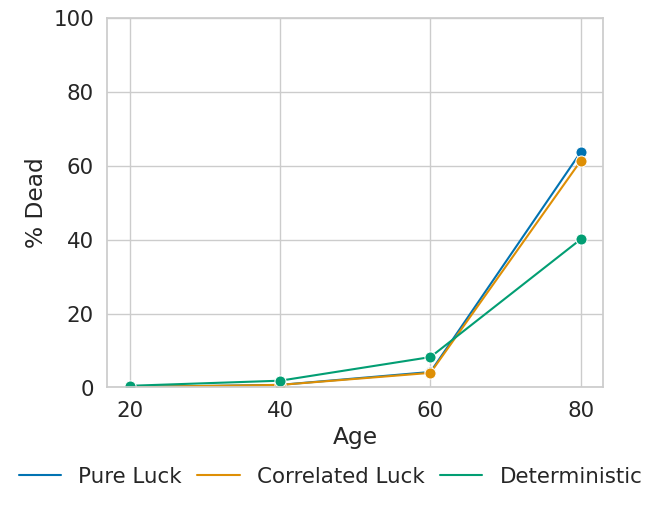

In [41]:
fig = sns.lineplot(data=percent_dead_df, hue='Model', x='variable', y='value', marker='o', markersize=8)
plt.xticks(ticks=[20,40,60,80])
plt.ylim(0,100)
plt.xlabel("Age")
plt.ylabel("% Dead")

fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.45,-0.32), ncol=3, title='', columnspacing=.7).get_frame().set_linewidth(0.0)

plt.savefig("./figures/appendix_figures/Appendix_6.png", dpi=600, bbox_inches='tight')

## Figure 3: Concentration Index Life-course

In [42]:
life_course_ci_df = pd.read_excel(dataset, sheet_name="life course CI graph")

In [43]:
life_course_ci_df = life_course_ci_df.dropna(how='all')

In [44]:
life_course_ci_df = life_course_ci_df.rename(columns={'This corresponds to Figure R4': 'Analysis', 'Unnamed: 1': 'Method', 'Unnamed: 2': 'Model', 'Unnamed: 3': 20, 'Unnamed: 4': 40, 'Unnamed: 5': 60, 'Unnamed: 6': 80,})
life_course_ci_df = life_course_ci_df[life_course_ci_df.Model != 'Model'].copy()
life_course_ci_df = life_course_ci_df.iloc[1:]
life_course_ci_df['Analysis'] = life_course_ci_df.Analysis.fillna(method='ffill')
life_course_ci_df['Method'] = life_course_ci_df.Method.fillna(method='ffill')

In [45]:
life_course_ci_df = life_course_ci_df.melt(id_vars=['Analysis', 'Method', 'Model'], value_vars=[20, 40, 60, 80])

In [46]:
life_course_ci_df['Model'] = life_course_ci_df.Model.replace(name_replacement)

In [47]:
life_course_ci_df = life_course_ci_df[life_course_ci_df.Model != 'High Correlated Luck Model']
gini_df = gini_df[gini_df.Model != 'High Correlated Luck Model']

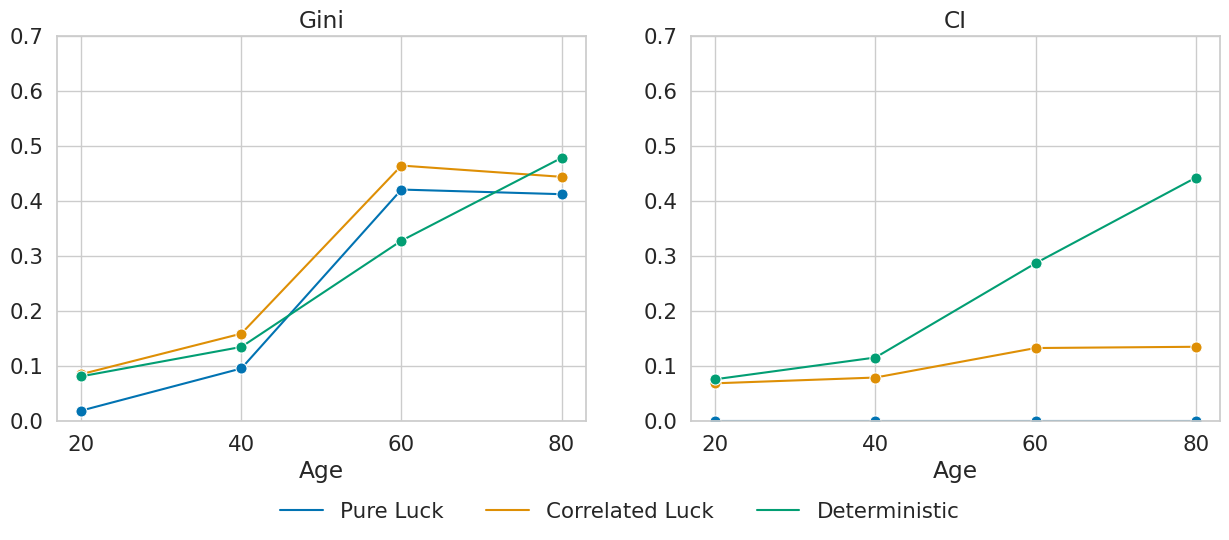

In [48]:
# Figure 3

fig, axs = plt.subplots(1, 2, figsize=(15,5))

plt.setp(axs, xticks=[20,40,60,80], yticks=np.arange(0, 0.8, 0.1), ylim=(0,0.7))

for i, (method, analysis) in enumerate([('E', 'Dead included'), ('E', 'Dead included')]):
    col = i

    if col == 1:
        sns.lineplot(data=life_course_ci_df[(life_course_ci_df.Method == method) & (life_course_ci_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[col], markersize=8)
        axs[col].set_xlabel("Age")
        m = "Wagstaff" if method == "W" else "Erreygers"
        if i >= 2:
            axs[col].set_title(f"CI", pad=-16)
            axs[col].set_xlabel("Age")
        else:
            axs[col].set_title(f"CI")
            axs[col].set_xlabel("Age")
            # axs[col].set_xticklabels([])

        legend = axs[col].legend()
        axs[col].legend().remove()

        axs[col].set_ylabel("")

    else:
        sns.lineplot(data=gini_df[(gini_df.Method == method) & (gini_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[col], markersize=8)
        m = "Wagstaff" if method == "W" else "Erreygers"
        if i >= 2:
            axs[col].set_title(f"Gini", pad=-16)
            axs[col].set_xlabel("Age")
        else:
            axs[col].set_title(f"Gini")
            axs[col].set_xlabel("Age")
            # axs[col].set_xticklabels([])
        
        axs[col].set_ylabel("")
        legend = axs[col].legend()
        axs[col].legend().remove()


fig.legend(labels=[label.rstrip(" Model") for label in axs[0].get_legend_handles_labels()[1]], handles=axs[0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.13), ncol=4, title='').get_frame().set_linewidth(0.0) # , fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)
fig.subplots_adjust(hspace=0.08)

fig.savefig("./figures/manuscript_figures/Figure_2.png", dpi=600, bbox_inches='tight')


## Cross-sectional Gini

In [49]:
cross_sectional_gini_df = pd.read_excel(dataset, sheet_name="cross-sectional Gini graph")

In [50]:
cross_sectional_gini_df = cross_sectional_gini_df.iloc[:, 6:]

In [51]:
cross_sectional_gini_df = cross_sectional_gini_df.dropna(how='all').iloc[1:]

In [52]:
cross_sectional_gini_df['Model'] = pd.to_numeric(cross_sectional_gini_df['Unnamed: 6'], errors='coerce')
cross_sectional_gini_df['Method'] = cross_sectional_gini_df['Unnamed: 6'].where(cross_sectional_gini_df['Model'].isna())

In [53]:
cross_sectional_gini_df = cross_sectional_gini_df.drop(columns='Unnamed: 6')

In [54]:
cross_sectional_gini_df['Method'] = cross_sectional_gini_df.Method.fillna(method='ffill')

In [55]:
cross_sectional_gini_df = cross_sectional_gini_df.rename(columns={'Unnamed: 7': 'Cross-sectional', 'Unnamed: 8': 'Zombie, dead included'})

In [56]:
cross_sectional_gini_df = cross_sectional_gini_df[cross_sectional_gini_df.Model.isna() == False].copy()

In [57]:
cross_sectional_gini_df['Model'] = cross_sectional_gini_df.Model.replace(name_replacement)

## Appendix 10A

In [58]:
sns.set_context("notebook", font_scale=1.5)

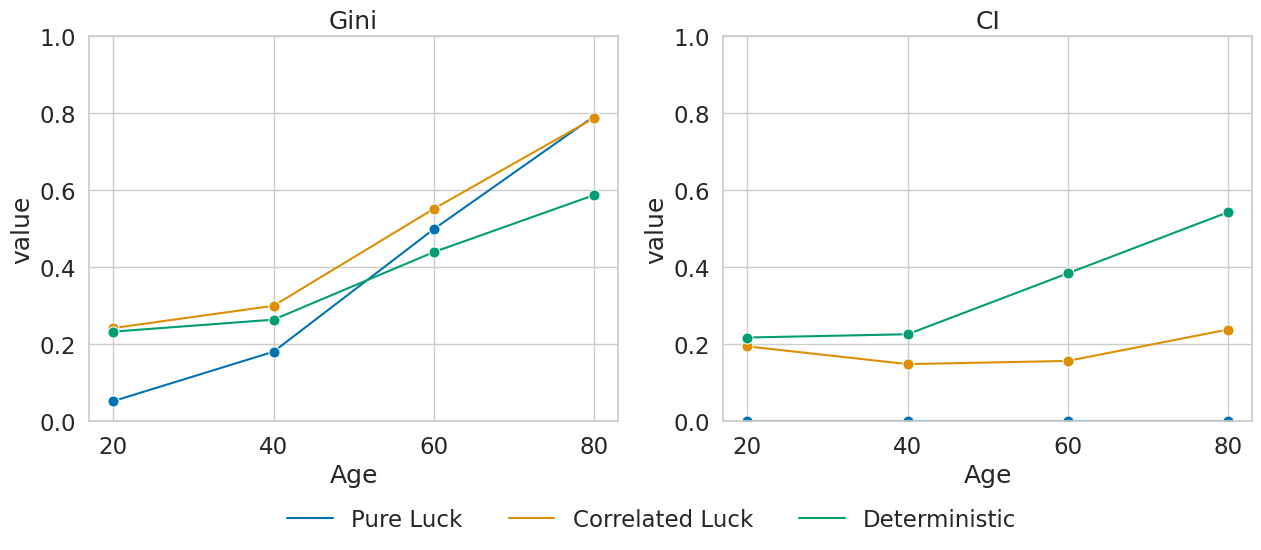

In [59]:
# Appendix 10A (Wagstaff variant of new Figure 3)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

plt.setp(axs, xticks=[20,40,60,80], yticks=np.arange(0, 1.1, 0.2), ylim=(0,1))

for i, (method, analysis) in enumerate([('W', 'Dead included'), ('W', 'Dead included')]):
    # row, col = np.unravel_index(i, (2, 2))
    col = i

    if col == 1:
        ...
        sns.lineplot(data=life_course_ci_df[(life_course_ci_df.Method == method) & (life_course_ci_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[col], markersize=8)
        axs[col].set_xlabel("Age") # , fontsize=12)
        m = "Wagstaff" if method == "W" else "Erreygers"
        if i >= 2:
            axs[col].set_title(f"CI", pad=-16) #, fontsize=14)
            axs[col].set_xlabel("Age") #, fontsize=12)
        else:
            axs[col].set_title(f"CI") #, fontsize=14)
            axs[col].set_xlabel("Age")
            # axs[col].set_xticklabels([])
        legend = axs[col].legend()
        axs[col].legend().remove()
    else:
        sns.lineplot(data=gini_df[(gini_df.Method == method) & (gini_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[col], markersize=8)
        m = "Wagstaff" if method == "W" else "Erreygers"
        if i >= 2:
            axs[col].set_title(f"Gini", pad=-16) #, fontsize=14)
            axs[col].set_xlabel("Age") #, fontsize=12)
        else:
            axs[col].set_title(f"Gini") # , fontsize=14)
            axs[col].set_xlabel("Age") #, fontsize=12)
            # axs[col].set_xlabel("")
            # axs[col].set_xticklabels([])
        legend = axs[col].legend()
        axs[col].legend().remove()

    # axs[row, col].set_ylim(0, 1)

# fig.suptitle("Concentration Index Life-course", y=0.95) #, fontsize=16)
# fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5,-0.03))
fig.legend(labels=[label.rstrip(" Model") for label in axs[0].get_legend_handles_labels()[1]], handles=axs[0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.15), ncol=4, title='').get_frame().set_linewidth(0.0) # , fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)
fig.subplots_adjust(hspace=0.08)

fig.savefig("./figures/appendix_figures/Appendix_10A.png", dpi=600, bbox_inches='tight')
